In [1]:
''' If you have issues with unfound packages, uncomment the pip install lines below'''
# ! pip install ipywidgets
# ! jupyter nbextension enable --py widgetsnbextension
# ! pip install matplotlib
# ! pip install pandas
''' If you have issues with unfound packages, uncomment the pip install lines above'''

' If you have issues with unfound packages, uncomment the pip install lines above'

In [2]:
from ipywidgets import *
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum
from ipywidgets import HBox, Label

# %matplotlib inline

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
class FileType(Enum):
    UNSUPPORTED = 0
    FASTA = 1
    GFT = 2
    
# TODO use this object to keep track of state information?
class State:
    fasta_file = None
    gft_file = None
    exon_start = None
    display_objects = {}
    
    def state_complete():
        return fasta_file is None
    
summary = {}

In [5]:
def graph_data(series):
    plt.plot(series)
    plt.ylabel('Y label')
    plt.xlabel('X label')
    plt.title('Title')
    plt.show()
    return plt

def read_gft(filename):
    gft = pd.read_csv(filename, sep=r'[;\t]', 
                     header=None, 
                     names=["seqname", "source", "feature", "coordinate1", "coordinate2", "score", "orientation", "frame", 
                            "gene_id", "transcript_id", "drop_me"],
                     engine='python')
    gft = gft.drop("drop_me", axis=1)
    return gft

def get_avg_gene_span(gft):
    spans = []
    for gid in gft.gene_id.unique():
        exon_coordinate_list = (gft[ gft.gene_id == gid].coordinate1).append(gft[ gft.gene_id == gid].coordinate2)
        gene_span = exon_coordinate_list.max() - exon_coordinate_list.min() + 1
        spans.append(gene_span)
    return pd.Series(spans).mean()

def get_avg_intergenic_space(gft):
    # intergenic space is min cordinate 1 of gene 2      max cordinate 2 of gene 1
    spacing = pd.DataFrame()
    spacing["left"] = gft.groupby("gene_id").coordinate1.min()
    spacing["right"] = gft.groupby("gene_id").coordinate1.max()
    diff = []
    for r in range(0, len(spacing) - 1):
        diff.append(spacing.iloc[r + 1].right - spacing.iloc[r].left)
    return pd.Series(diff).mean()

def get_avg_length(gft, condition):
    gft = gft[condition]
    spacing = pd.DataFrame()
    spacing["left"] = gft.coordinate1
    spacing["right"] = gft.coordinate2
    diff = []
    for r in range(0, len(spacing) - 1):
            diff.append(spacing.iloc[r].left - spacing.iloc[r + 1].right + 1)
    return pd.Series(diff).mean()


def process_gft(gft):
    global summary
    summary["Number of Genes"] = gft.gene_id.nunique()
    summary["Gene Density"] = gft.gene_id.nunique() / gft.gene_id.count()
    summary["Average Gene Span"] = get_avg_gene_span(gft[gft.feature != "stop_codon"])
    summary["Average Intergenic Spaces"] = get_avg_intergenic_space(gft) 
    
    summary["Average Intron Length"] = get_avg_length(gft, gft.feature == "exon")
    
    summary["Number of Exons"] = gft[gft.feature == "exon"].seqname.count()
    summary["Number of Introns"] = summary["Number of Exons"] - 1
    summary["Average Exon Length"] = (gft[gft.feature != "stop_codon"].coordinate2 - gft[gft.feature != "stop_codon"].coordinate1 + 1).mean()
    
    summary["Average GC Content"] = "Use information from the fasta file!"
    
    coors = gft.coordinate1.append(gft.coordinate2)
    #     summary["max"] = int(coors.max())
    #     summary["min"] = int(coors.min())
    return summary
    
def read_lab1(filename):
    seq = ""
    with open(filename) as file:
        line1 = file.readline()
        seq = file.readline().upper()
    d = {'A': [], 'C': [], 'G': [], 'T': [], 'N': []}
    for s in seq:
        d[s].append(1)
        for k in d.keys():
            if k is not s:
                d[k].append(0)
    df = pd.DataFrame(d)
    return df
    
def analyze_lab1(df):
    total_gc = df.C.mean() + df.G.mean()
    global summary 
    summary["Average GC Content:"] = total_gc
    summary["Total Unknown:"] = df.N.mean()
    
    s = int(df.shape[0])
    window_size = int(s / 20)
    plt.plot(total_gc)
    off = int(s/float(66.6))

    # TODO make this better. 
    if off == 0:
        plt.plot(get_averages(df, s, window_size, offset=0)[0])
    else:
        for o in range(0, window_size, off):
            plt.plot(get_averages(df, s, window_size, offset=o)[0])

    plt.ylabel('Percentage')
    plt.xlabel('Window Number')
    plt.title('GC Percentage')
    plt.show()
    return plt

def get_averages(df, s, window_size, offset=0, print_me=False):
    rolling_avg = []
    window = []
    for i in range(offset, s, window_size):
        gc = df.iloc[i : i + window_size].G.mean() + df.iloc[i : i + window_size].C.mean()
        if print_me:
            print("window: ", i, i + window_size, "\t the gc content is: ", gc, "unknown: ", df.iloc[i : i + window_size].N.mean())
        rolling_avg.append(gc)
        window.append((i, i+window_size))
    return rolling_avg, window
    

def handle_gft(fname):
    filename = "data/" + fname
    file_type = FileType.GFT
    with open(filename) as file:
        line1 = file.readline()
        # TODO some type check for is GFT or GFF file!
        if line1[0] is '>':
            raise UserWarning("That file type is unsupported. Exiting.")
            sys.exit(-1)
    df = read_gft(filename)
    summary = process_gft(df)
    return summary

def handle_fasta(fname):
    filename = "data/" + fname
    file_type = FileType.FASTA
    with open(filename) as file:
        line1 = file.readline()
        # TODO additional type check for is GFT or GFF file!
        if line1[0] is not '>':
            raise UserWarning("That file type is unsupported. Exiting.")
            sys.exit(-1)
    df = read_lab1(filename)
    analyze_lab1(df)
    #     plt_instance = graph_lab1(df)

    print("\n".join("{}: {}".format(k, v) for k, v in summary.items()))
    #     return plt_instance

Dropdown(description='GFT:', options=('gft1.txt', 'DNA.txt', 'customgft.txt'), value='gft1.txt')

Dropdown(description='FASTA:', options=('gft1.txt', 'DNA.txt', 'customgft.txt'), value='gft1.txt')

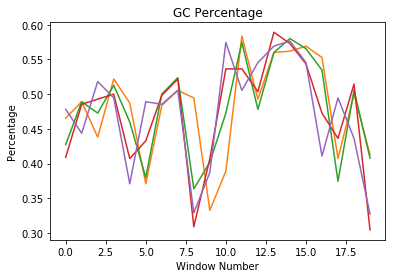

Number of Genes: 1
Gene Density: 0.07692307692307693
Average Gene Span: 5814.0
Average Intergenic Spaces: nan
Average Intron Length: 714.8
Number of Exons: 6
Number of Introns: 5
Average Exon Length: 375.0
Average GC Content: Use information from the fasta file!
Average GC Content:: 0.48090909090909095
Total Unknown:: 0.0


In [6]:
# This is the display UI code which calls event handler code
# get all the file names in the data folder and display for our users
files = [f for f in os.listdir('data') if os.path.isfile(os.path.join("data", f))]

current = State()
gtf_dropdown = widgets.Dropdown(options= files, description= "GFT:")
fasta_dropdown = widgets.Dropdown(options= files, description= "FASTA:")
exon_start = widgets.BoundedIntText(
    value = 7,
    min = 0,
    max = 10,
    step=1,
    description='Start : ',
    disabled=False
)

current.display_objects["gtf_dropdown"] =  gtf_dropdown
current.display_objects["fasta_dropdown"] = fasta_dropdown
current.display_objects["exon_start"] = exon_start

def is_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        return change['new']
    return None

def fasta_selection(dd):
    if is_change(dd):
        return handle_fasta(is_change(dd))
    return None

def gft_selection(dd):
    if is_change(dd):
        global summary
        summary = handle_gft(is_change(dd))
#         exon_start.max = summary["max"]
#         exon_start.min = summary["min"]
        display(fasta_dropdown)
    return None

o = gtf_dropdown.observe(gft_selection)
o = fasta_dropdown.observe(fasta_selection)

display(gtf_dropdown)

In [7]:
seq = ""
with open("data/DNA.txt") as file:
    line1 = file.readline()
    seq = file.readline().upper()
my_sequence = seq

In [8]:
from Bio.Seq import Seq

#create a sequence object
my_seq = Seq('CATGTAGACTAG')

#print out some details about it
print( 'seq %s is %i bases long' % (my_seq, len(my_seq)))
print( 'reverse complement is %s' % my_seq.reverse_complement())
print( 'protein translation is %s' % my_seq.translate())

seq CATGTAGACTAG is 12 bases long
reverse complement is CTAGTCTACATG
protein translation is HVD*


In [9]:
def frequentWords( s, k ):
    counts = {}
    for i in range(0,len(s)-k+1):
        if s[i:i+k] not in counts:
            counts[s[i:i+k]] = 0
        counts[s[i:i+k]] += 1
    
    m = max(counts.values())
    out = []
    
    for kmer in counts:
        if counts[kmer] == m:
            out.append(kmer)
    return out

f = frequentWords(my_sequence, 20)

In [10]:
from Bio import motifs

instances = []
for w in f:
    instances.append(Seq(w))
    
m = motifs.create(instances)
instances

[Seq('TGTATTTATGTTTTTTTGTT', Alphabet()),
 Seq('GTATTTATGTTTTTTTGTTT', Alphabet()),
 Seq('TATTTATGTTTTTTTGTTTA', Alphabet()),
 Seq('ATTTATGTTTTTTTGTTTAT', Alphabet()),
 Seq('TTTATGTTTTTTTGTTTATT', Alphabet()),
 Seq('CCGAAGTCGCAGCAGTGAAC', Alphabet()),
 Seq('CGAAGTCGCAGCAGTGAACG', Alphabet()),
 Seq('GAAGTCGCAGCAGTGAACGA', Alphabet()),
 Seq('AAGTCGCAGCAGTGAACGAA', Alphabet())]

In [11]:
test_seq=Seq(my_sequence, m.alphabet)
test_seq

Seq('CCCGGTGGAATGGTCGATCCCGGCGAGAATGTCAGTGTCACCCTTAAGCGGGAG...GCA', IUPACUnambiguousDNA())

In [12]:
for pos, seq in m.instances.search(test_seq):
    print("%i %s" % (pos, seq))

5651 TGTATTTATGTTTTTTTGTT
5652 GTATTTATGTTTTTTTGTTT
5653 TATTTATGTTTTTTTGTTTA
5654 ATTTATGTTTTTTTGTTTAT
5655 TTTATGTTTTTTTGTTTATT
5682 TGTATTTATGTTTTTTTGTT
5683 GTATTTATGTTTTTTTGTTT
5684 TATTTATGTTTTTTTGTTTA
5685 ATTTATGTTTTTTTGTTTAT
5686 TTTATGTTTTTTTGTTTATT
10401 CCGAAGTCGCAGCAGTGAAC
10402 CGAAGTCGCAGCAGTGAACG
10403 GAAGTCGCAGCAGTGAACGA
10404 AAGTCGCAGCAGTGAACGAA
10440 CCGAAGTCGCAGCAGTGAAC
10441 CGAAGTCGCAGCAGTGAACG
10442 GAAGTCGCAGCAGTGAACGA
10443 AAGTCGCAGCAGTGAACGAA


In [13]:
len(seq)

20